# This workbooks provides a tool to pre-select sources to be spectroscopically analyzed with SAMOS.

## It is divided in 4 main parts:

### 1) Selection of the target catalog

### 2) Display of the targets and pre-selection of the slits

### 3) Ranking and final slit list(s)

### 4) Selection of suitable guide stars

## Initial imports

In [1]:
#import ipyaladin.aladin_widget as ipyal
from ipyaladin import Aladin
from ipywidgets import Layout#, Box, widgets
import pandas as pd
from astroquery.simbad import Simbad
import astropy.units as u
from astropy import coordinates#, units as u, wcs

from astroquery.vizier import Vizier
from astropy.io.votable import parse
from astropy.table import Table, Column
import numpy as np
import matplotlib.pyplot as plt
import copy

from regions import RectangleSkyRegion, Regions
from astropy.coordinates import SkyCoord
#from astropy import units as u
import os as os
#import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle
    
from astropy.wcs import WCS
import astropy.wcs as wcs
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
#from astropy import units as u
from astropy.visualization.wcsaxes import Quadrangle
#from astropy.coordinates import SkyCoord

from astropy.time import Time
#from astropy.io import fits

import astropy.coordinates as coord
from astroquery.gaia import Gaia
import urllib.request
import shutil
import tempfile
import re

from regions import PixCoord

import pyvo as vo
from astropy.utils.data import download_file
from astropy.nddata import Cutout2D

%matplotlib inline

In [2]:
#SETUP THE DIRECTORY

cwd = os.getcwd()

#Target_name = "M 13"
#Target_name = "IDCS J1426.5+3508"
#Target_name = "M 42"
Target_name = "NGC 3105"
#Target_name = "NGC 6281"
#Target_name = "Sh2-210"
# NORTHERN EXAMPLE: 
#Target_name = "Crab Nebula"
#    ra = 83.633210
#    dec = 22.014460

dir_name = os.path.join(cwd, Target_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
filename = Target_name+"_slits.reg"

## Step 0: declare the target field and get the Simbad coordinates

In [3]:
result_table = Simbad.query_object(Target_name)
print(result_table)

ra = result_table['RA']
dec = result_table['DEC']

radec_center = coord.SkyCoord(ra,dec,unit=(u.hourangle,u.deg), frame='icrs')
Posx = radec_center.ra.value[0] ; print(Posx.dtype)
Posy = radec_center.dec.value[0]; print(Posy.dtype)
Pos = SkyCoord(ra=Posx, dec=Posy, unit='deg')

print(radec_center.ra.value[0],radec_center.dec.value[0])
print(Posx)

 MAIN_ID      RA        DEC    ...     COO_BIBCODE     SCRIPT_NUMBER_ID
           "h:m:s"    "d:m:s"  ...                                     
--------- ---------- --------- ... ------------------- ----------------
NGC  3105 10 00 40.6 -54 47 24 ... 2021A&A...647A..19T                1
float64
float64
150.16916666666665 -54.79
150.16916666666665


# STEP 1) Selection of the target catalog¶
   
## We illustrate 4 ways to create the source catalog

### 1.1) Simbad: Extract Astropy table from the entries on Simbad, generally just a mix of sources

### 1.2) Vizier: Extract Astropy table from published dataset on Vizier

### 1.3) Create and Astropy table from your own catalog on local disk

### 1.4) Vizier+your own: Create an astropy table from my file + Vizier X-match


# 1.1) Simbad: Extract Astropy table from Simbad

We start extracting all objects that have an entry on Simbad, i.e. sources that appear in published journal catalogs. 

"This is a class designed to represent tables of heterogeneous data. It is better than a numpy structured array because of the ability to easily modify the structure of the table by adding or removing columns, or adding new rows of data. In addition table and column metadata are fully supported." 

See 
http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table

In [4]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN THIS CELL
#=======================================

#simbad.SIMBAD_URL = 'http://simbad.harvard.edu/simbad/sim-script'

#To query Simbad, see https://astroquery.readthedocs.io/en/latest/simbad/simbad.html
#result_table = simbad.query_region("m81", radius="0.5d")
table_1 = Simbad.query_region(Target_name, radius="0.05d")

#this defines the Astropy"table" that we will use later
#
print(table_1.colnames)
print(table_1)

['MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA', 'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH', 'COO_BIBCODE', 'SCRIPT_NUMBER_ID']
          MAIN_ID                  RA      ... SCRIPT_NUMBER_ID
                                "h:m:s"    ...                 
---------------------------- ------------- ... ----------------
                   NGC  3105    10 00 40.6 ...                1
Gaia DR3 5260177495457182464 10 00 40.6092 ...                1
                 AM 0958-543      10 00 41 ...                1
Gaia DR3 5260177495457181824 10 00 40.5349 ...                1
Gaia DR3 5260177499778947072 10 00 40.5857 ...                1
Gaia DR3 5260177499778947200 10 00 40.3553 ...                1
                         ...           ... ...              ...
                   ALS 18474    10 00 22.4 ...                1
Gaia DR3 5260183474051660928 10 00 57.5162 ...                1
Gaia DR3 5260183474051309952 10 00 56.9997 ...                1
Gaia D

In [5]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN THIS CELL
#=======================================
# ... and some preparation may be needed, for example
#table_1.rename_column('RAJ2000', 'RA')
#table_1.rename_column('DEJ2000', 'DEC')
#table_1.rename_column('ID', 'MainID')

#add an "index" column
table_1.add_column(np.arange(len(table_1)), name='index', index=0)
print(table_1.colnames)



['index', 'MAIN_ID', 'RA', 'DEC', 'RA_PREC', 'DEC_PREC', 'COO_ERR_MAJA', 'COO_ERR_MINA', 'COO_ERR_ANGLE', 'COO_QUAL', 'COO_WAVELENGTH', 'COO_BIBCODE', 'SCRIPT_NUMBER_ID']


# 1.2) Vizier: Extract Astropy table from published dataset on Vizier

## example here is Gaia DR2, or any other table from a published paper (go to find it...)

In [6]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================


center = coordinates.SkyCoord.from_name(Target_name)

Vizier.ROW_LIMIT = -1
tablelist = Vizier.query_region(center, radius=2*u.arcmin,
#                                catalog='J/ApJ/826/16/table1')
#                                catalog='J/A+A/616/A124'
                               catalog='I/345/gaia2',column_filters={'Gmag': '<19'})
# Vizier.query_region returns a "tablelist" table, 
# a class that inherits from list but included some pretty printing methods for astropy.table.Table objects.
#see
#https://astroquery.readthedocs.io/en/latest/api/astroquery.utils.TableList.html#astroquery.utils.TableList

# the result may be a list of tables, so here we'll get the first one
table_2 = tablelist[0]
#print(table_2[0:5])

#CHECK!
print(table_2.colnames)
table_2

['RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', 'FG', 'e_FG', 'Gmag', 'e_Gmag', 'FBP', 'e_FBP', 'BPmag', 'e_BPmag', 'FRP', 'e_FRP', 'RPmag', 'e_RPmag', 'BP-RP', 'RV', 'e_RV', 'Teff', 'AG', 'E_BP-RP_', 'Rad', 'Lum']


RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Source,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
150.20927750333,0.0783,-54.81138383982,0.0725,5260176670827454848,0.2056,0.0927,-4.727,0.156,3.745,0.133,0,1939,2.097,17.4696,0.0012,791.1,8.713,18.1059,0.0120,1980,11.63,16.5202,0.0064,1.5856,--,--,--,--,--,--,--
150.21792985371,0.1875,-54.80318918529,0.1328,5260176709495742080,0.5791,0.1867,-6.109,0.357,5.615,0.244,0,987.8,4.071,18.2017,0.0045,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
150.21546756094,0.1297,-54.80275911829,0.1213,5260176705183229056,0.3169,0.1506,17.048,0.264,-4.954,0.226,0,832.1,1.325,18.3879,0.0017,351.1,5.488,18.9877,0.0170,770.1,7.621,17.5456,0.0107,1.4421,--,--,--,--,--,--,--
150.20923546453,0.0315,-54.81035681808,0.0284,5260176675145227136,0.5338,0.0355,-12.167,0.062,4.922,0.053,0,1.023e+04,5.44,15.6638,0.0006,5165,10.78,16.0688,0.0023,7466,11.6,15.0791,0.0017,0.9896,--,--,5287.00,--,--,1.45,1.488
150.21780452443,0.0373,-54.80356043738,0.0332,5260176709504974464,0.5858,0.0406,-7.942,0.081,8.174,0.063,0,1.052e+04,6.586,15.6333,0.0007,5369,17.85,16.0266,0.0036,8424,34.99,14.9482,0.0045,1.0784,--,--,5037.13,--,--,1.51,1.326
150.21485052985,0.0240,-54.80725806920,0.0217,5260176709504970496,0.8438,0.0274,-1.597,0.048,5.673,0.040,0,1.655e+04,5.487,15.1414,0.0004,8500,12.69,15.5278,0.0016,1.192e+04,13.11,14.5715,0.0012,0.9563,--,--,5258.75,0.4673,0.2350,1.18,0.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150.17721055383,0.0774,-54.75928381376,0.0765,5260177843376354432,0.1288,0.0931,-4.348,0.162,2.738,0.145,0,2073,2.211,17.3968,0.0012,860,8.706,18.0151,0.0110,1823,15.09,16.6101,0.0090,1.4051,--,--,--,--,--,--,--


In [7]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================


# ... and some preparation may be needed

table_2.rename_column('RA_ICRS', 'RA')
table_2.rename_column('DE_ICRS', 'DEC')
table_2.rename_column('Source', 'MainID')
table_2.add_column(np.arange(len(table_2)), name='index', index=0)

In [8]:
table_2

index,RA,e_RA_ICRS,DEC,e_DE_ICRS,MainID,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
,deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
int64,float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
0,150.20927750333,0.0783,-54.81138383982,0.0725,5260176670827454848,0.2056,0.0927,-4.727,0.156,3.745,0.133,0,1939,2.097,17.4696,0.0012,791.1,8.713,18.1059,0.0120,1980,11.63,16.5202,0.0064,1.5856,--,--,--,--,--,--,--
1,150.21792985371,0.1875,-54.80318918529,0.1328,5260176709495742080,0.5791,0.1867,-6.109,0.357,5.615,0.244,0,987.8,4.071,18.2017,0.0045,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
2,150.21546756094,0.1297,-54.80275911829,0.1213,5260176705183229056,0.3169,0.1506,17.048,0.264,-4.954,0.226,0,832.1,1.325,18.3879,0.0017,351.1,5.488,18.9877,0.0170,770.1,7.621,17.5456,0.0107,1.4421,--,--,--,--,--,--,--
3,150.20923546453,0.0315,-54.81035681808,0.0284,5260176675145227136,0.5338,0.0355,-12.167,0.062,4.922,0.053,0,1.023e+04,5.44,15.6638,0.0006,5165,10.78,16.0688,0.0023,7466,11.6,15.0791,0.0017,0.9896,--,--,5287.00,--,--,1.45,1.488
4,150.21780452443,0.0373,-54.80356043738,0.0332,5260176709504974464,0.5858,0.0406,-7.942,0.081,8.174,0.063,0,1.052e+04,6.586,15.6333,0.0007,5369,17.85,16.0266,0.0036,8424,34.99,14.9482,0.0045,1.0784,--,--,5037.13,--,--,1.51,1.326
5,150.21485052985,0.0240,-54.80725806920,0.0217,5260176709504970496,0.8438,0.0274,-1.597,0.048,5.673,0.040,0,1.655e+04,5.487,15.1414,0.0004,8500,12.69,15.5278,0.0016,1.192e+04,13.11,14.5715,0.0012,0.9563,--,--,5258.75,0.4673,0.2350,1.18,0.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,150.17721055383,0.0774,-54.75928381376,0.0765,5260177843376354432,0.1288,0.0931,-4.348,0.162,2.738,0.145,0,2073,2.211,17.3968,0.0012,860,8.706,18.0151,0.0110,1823,15.09,16.6101,0.0090,1.4051,--,--,--,--,--,--,--


# 1.3) Extract Astropy tablefrom your own catalog on disk

## you need to prepare it first...!

In [9]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================

#Read a CSV file as a pandas file
catfile = './M42/Slimtable_F130&MainIDfixed_8782.csv'
pandacat = pd.read_csv(catfile)

#check...
pandacat.head()

#to create an astropy table, use
table_3 = Table.from_pandas(pandacat)
print(table_3[0:5])

index MainID OtherID       RA     ...   dcolor    Delta130  Delta139 Nr_IR
----- ------ -------- ----------- ... ---------- --------- --------- -----
    0      0  44-1078 83.62638127 ...   0.115685 0.0610695  0.563724     3
    1      1 26-47-65 83.60899771 ...  0.0172287 0.0611172 0.0769806     4
    2      2       48  83.6163478 ... 0.00717064 0.0273504 0.0428772     2
    3      3      122 83.63294382 ...  0.0207105 0.0713882  0.026536     2
    4      4       50 83.61754036 ...   0.018213 0.0280094 0.0634899     2


# 1.4)  Vizier+your own: Create an astropy table from my file + Vizier X-match 

## again, assumes you have done preparatory work...

In [10]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================

#The X-match output table is a VOTable. Must handled with care, Pandas seems to work.

#Routine is required to read VOTable => Pandas
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

#here we go...
catfile = './M42/Slimtable.csv.vot'
pandacat_4  = votable_to_pandas(catfile)

pandacat_4.head()

#to create an astropy table, use
table_4 = Table.from_pandas(pandacat_4)
print(table_4[0:5])

index     RA       DEC       X_mos    ...   dcolor    Delta130  Delta139
----- --------- --------- ----------- ... ---------- --------- ---------
    0 83.626381 -5.457797 10112.93708 ...   0.115685 0.0610695  0.563724
    1 83.608998 -5.441777 10598.80566 ...  0.0172287 0.0611172 0.0769806
    2 83.616348 -5.442953 10393.40753 ... 0.00717064 0.0273504 0.0428772
    3 83.632944 -5.443575 9929.648054 ...  0.0207105 0.0713882  0.026536
    4  83.61754 -5.444363 10360.07306 ...   0.018213 0.0280094 0.0634899


### We have shown 4 methods and created 4 tables: table_1, table_2 table_3, table_4

# SELECT A TABLE TO WORK WITH

In [11]:
#WE SELECT GAIA DR2 CATALOG PROVIDED BY VIZIER

main_ap_table = table_2
main_ap_table

index,RA,e_RA_ICRS,DEC,e_DE_ICRS,MainID,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,FG,e_FG,Gmag,e_Gmag,FBP,e_FBP,BPmag,e_BPmag,FRP,e_FRP,RPmag,e_RPmag,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum
,deg,mas,deg,mas,,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,mag,mag,,,mag,mag,,,mag,mag,mag,km / s,km / s,K,mag,mag,solRad,solLum
int64,float64,float64,float64,float64,int64,float64,float32,float64,float32,float64,float32,uint8,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float32,float64,float32,float32,float32,float64
0,150.20927750333,0.0783,-54.81138383982,0.0725,5260176670827454848,0.2056,0.0927,-4.727,0.156,3.745,0.133,0,1939,2.097,17.4696,0.0012,791.1,8.713,18.1059,0.0120,1980,11.63,16.5202,0.0064,1.5856,--,--,--,--,--,--,--
1,150.21792985371,0.1875,-54.80318918529,0.1328,5260176709495742080,0.5791,0.1867,-6.109,0.357,5.615,0.244,0,987.8,4.071,18.2017,0.0045,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
2,150.21546756094,0.1297,-54.80275911829,0.1213,5260176705183229056,0.3169,0.1506,17.048,0.264,-4.954,0.226,0,832.1,1.325,18.3879,0.0017,351.1,5.488,18.9877,0.0170,770.1,7.621,17.5456,0.0107,1.4421,--,--,--,--,--,--,--
3,150.20923546453,0.0315,-54.81035681808,0.0284,5260176675145227136,0.5338,0.0355,-12.167,0.062,4.922,0.053,0,1.023e+04,5.44,15.6638,0.0006,5165,10.78,16.0688,0.0023,7466,11.6,15.0791,0.0017,0.9896,--,--,5287.00,--,--,1.45,1.488
4,150.21780452443,0.0373,-54.80356043738,0.0332,5260176709504974464,0.5858,0.0406,-7.942,0.081,8.174,0.063,0,1.052e+04,6.586,15.6333,0.0007,5369,17.85,16.0266,0.0036,8424,34.99,14.9482,0.0045,1.0784,--,--,5037.13,--,--,1.51,1.326
5,150.21485052985,0.0240,-54.80725806920,0.0217,5260176709504970496,0.8438,0.0274,-1.597,0.048,5.673,0.040,0,1.655e+04,5.487,15.1414,0.0004,8500,12.69,15.5278,0.0016,1.192e+04,13.11,14.5715,0.0012,0.9563,--,--,5258.75,0.4673,0.2350,1.18,0.967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,150.17721055383,0.0774,-54.75928381376,0.0765,5260177843376354432,0.1288,0.0931,-4.348,0.162,2.738,0.145,0,2073,2.211,17.3968,0.0012,860,8.706,18.0151,0.0110,1823,15.09,16.6101,0.0090,1.4051,--,--,--,--,--,--,--


## Get the sources within 180"x180" FoV

[0.06696770338807034 0.06696770338807034 0.06696770338807034
 0.06696770338807034 0.06696770338807034 0.06696770338807034]
We start with a table containing 458  targets
...and we end up with 347  sources


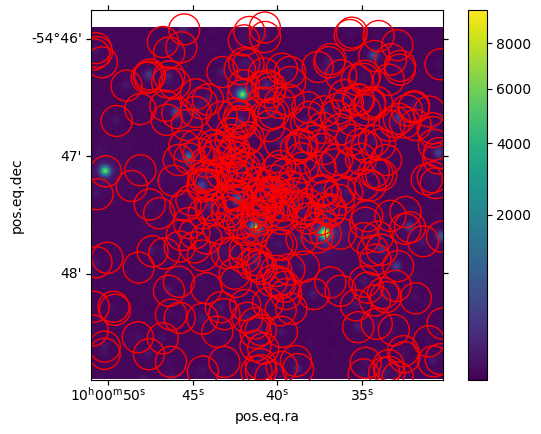

In [12]:
### Create a deep copy of the table to save the one selected 
main_ap_table_infield = copy.deepcopy(main_ap_table)

#Define a rectangular astropy region 180" x 180"
rr=RectangleSkyRegion(radec_center[0],180*u.arcsec,180*u.arcsec)

#To use the .contain method, we need a WCS. To get something on sky, 
#we get the WCS from 2MASS.
#We follow here the example on https://irsa.ipac.caltech.edu/docs/program_interface/sia_2mass_allsky.html

# Lookup and define a service for 2MASS images
# Start at STScI VAO Registry at https://vao.stsci.edu/keyword-search/
# Limit by Publisher "NASA/IPAC Infrared Science Archive" and Capability Type "Simple Image Access Protocol" then search on "2MASS"
# Locate the SIA URL https://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_sia?type=at&ds=asky&
#import pyvo as vo
twomass_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/cgi-bin/2MASS/IM/nph-im_sia?type=at&ds=asky&")

# Search the service
# Search for images covering within 1 arcsecond of the star
im_table = twomass_service.search(pos=Pos, size=1.0*u.arcsec)

# for debug
# Examine the table of images that is returned
im_table.to_table()

# Locate and download an image of interest
#There are multiple images, we want to take the one that is centered closed to our target to get full field coverage
#calculate the distances from tall the center images
d_from_center= np.sqrt( ( (im_table['center_ra']-Posx)/np.cos(im_table['center_dec']*u.deg))**2 +
                        (im_table['center_dec']-Posy)**2 )
#check:
print(d_from_center)


#loop over the images to get the first one with the minimum distance
mini = d_from_center[0]
i_mini = 0
for i in range(len(im_table)):
#    print(i,d_from_center[i],mini)
    if d_from_center[i] < mini:
        mini = d_from_center[i]
        i_mini=i
#print(i_mini)
#print(im_table[i_mini].getdataurl())

# Download the image and open it in Astropy
#from astropy.utils.data import download_file
fname = download_file(im_table[i_mini].getdataurl(), cache=True)
image1 = fits.open(fname)
filter=image1[0].header['FILTER']

# Extract a cutout of 180"x180"
wcs = WCS(image1[0].header)
#from astropy.nddata import Cutout2D
cutout = Cutout2D(image1[0].data, Pos, (180, 180), wcs=wcs)
#cutout.writeto(dir_name+"/Target_Field_2MASSradec_center[0].to_string()+".fits",overwrite=True)
wcs = cutout.wcs

# Put the cutout image in the FITS HDU
# Update the FITS header with the cutout WCS
hdu = fits.PrimaryHDU(data=cutout.data)
hdu.header.update(cutout.wcs.to_header())
hdu.data = cutout.data

# Write the cutout to a new FITS file
cutout_filename = dir_name+"/"+Target_name+"_2Mass_"+filter+"_"+radec_center[0].to_string()+".fits"
hdu.writeto(cutout_filename, overwrite=True)


#plot it...
fig = plt.figure()
# Create an ImageNormalize object using a SqrtStretch object
vmin=np.nanmin(cutout.data)
vmax=np.nanmax(cutout.data)
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())
ax = fig.add_subplot(1, 1, 1, projection=wcs)
#ax.imshow(cutout.data, cmap='gray_r', origin='lower', norm=norm)
im = ax.imshow(cutout.data, origin='lower', norm=norm)
ax.scatter(Posx,Posy, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
fig.colorbar(im)


#SELECT SOURCES FALLING INSIDE THE 180"x180" region
#get the RADEC of all sources in the table
all_RADEC = SkyCoord(ra=main_ap_table['RA'], dec=main_ap_table['DEC'], unit='deg')
print("We start with a table containing", len(all_RADEC)," targets")
main_ap_table_infield['in_field']='OUT'
for i in range(len(main_ap_table)):
#    print(len(main_ap_table_infield))
    if rr.contains(all_RADEC[i],wcs):
        main_ap_table_infield['in_field'][i]='IN'
        #print(i,"yes")
        ax.scatter(all_RADEC[i].ra, all_RADEC[i].dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
    else:
#        main_ap_table_infield['RA']==np.nan
        #print(i,"no")
        continue
#bad = np.logical_or.reduce([np.isnan(col) for col in main_ap_table_infield.itercols()])
#print(bad)
mask = np.logical_or.reduce([c == 'OUT' for c in main_ap_table_infield.columns.values()])
#print(mask)
main_ap_table_infield = main_ap_table_infield[~mask]
#print("", len(all_RADEC)," targets")
print("...and we end up with",len(main_ap_table_infield)," sources")


In [13]:
#hdu = fits.PrimaryHDU(data=cutout.data)
#hdu.header
image1[0].header['FILTER']
#print(hdu)

'j'

# PART 2) Display of the targets and pre-selection of the slits

## ALADIN display
It is based on the examples of the ipyaladin module, avaialable at https://github.com/cds-astro/ipyaladin , in particular Example 8_Rectangular-selection.ipynb



# For a list of good surveys, check https://aladin.u-strasbg.fr/AladinLite/

For example

#aladin= ipyal.Aladin(fov= 2.5, target= 'm42', survey='P/allWise/color')

aladin = ipyal.Aladin(target='M 42', fov=1.5, survey='P/2MASS/color')

aladin

In [14]:
# We go with 2Mass
aladin = Aladin(
    layout=Layout(width="50%"),
    target=Target_name,
    fov=0.055,
    survey='P/2MASS/color',
    show_projection_control=False,
    show_fullscreen_control=False,
)
aladin

Aladin(fov=0.055, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opa…

In [15]:
#Some preparatory work for the display, needed to help you...

dec_north = str(Posy + 90/3600)
dec_south = str(Posy - 90/3600)
ra_east = str( Posx + (90/3600 / np.cos(Posy*u.deg) ) )
ra_west = str( Posx - (90/3600 / np.cos(Posy*u.deg) ) )
print(dec_north,dec_south,ra_east,ra_west)
#Display square
square = "Polygon ICRS " + ra_east + " " + dec_south + " " + ra_west + " " + dec_south + " " + ra_west + " " + dec_north + " " + ra_east + " " + dec_north + " " + ra_east + " " + dec_south
print(square)
aladin.add_overlay_from_stcs(""+square+"",color="red")



-54.765 -54.815 150.21252616578678 150.12580716754653
Polygon ICRS 150.21252616578678 -54.815 150.12580716754653 -54.815 150.12580716754653 -54.765 150.21252616578678 -54.765 150.21252616578678 -54.815


In [16]:
#overplot to check our pre-selected sources
aladin.add_table(main_ap_table_infield)

print("there are ",len(main_ap_table_infield)," sources")

#MOVE THE MOUSE ON THE IMAGE!


there are  347  sources


Next step:

# PART 3) Ranking and final slit list(s)

## Use Pandas to set the ranking

### First, convert the table to Pandas then check the fields of the columns

In [17]:
main_pdtable = main_ap_table_infield.to_pandas()
#main_pdtable = main_pdtable[main_pdtable['index'].isin(indici.astype(int))]

In [18]:
main_pdtable.columns

Index(['index', 'RA', 'e_RA_ICRS', 'DEC', 'e_DE_ICRS', 'MainID', 'Plx',
       'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', 'FG', 'e_FG',
       'Gmag', 'e_Gmag', 'FBP', 'e_FBP', 'BPmag', 'e_BPmag', 'FRP', 'e_FRP',
       'RPmag', 'e_RPmag', 'BP-RP', 'RV', 'e_RV', 'Teff', 'AG', 'E_BP-RP_',
       'Rad', 'Lum', 'in_field'],
      dtype='object')

### Sort the table using some criteria, then create new table`

## Divide Targets from Fillers

### a) sort by Teff

In [19]:
main_pdtable_sorted  = main_pdtable.sort_values(by=['Teff'])

In [20]:
## b) split the TARGETS FROM THE FILLERS

In [21]:
main_pdtable_sorted['rank']="FILLER"
main_pdtable_sorted.loc[main_pdtable_sorted["Teff"] >4000,"rank"] = "TARGET" 
main_pdtable_sorted

,index,RA,e_RA_ICRS,DEC,e_DE_ICRS,MainID,Plx,e_Plx,pmRA,e_pmRA,...,BP-RP,RV,e_RV,Teff,AG,E_BP-RP_,Rad,Lum,in_field,rank
271,371,150.154748,0.0523,-54.794347,0.0492,5260177705937370880,0.2170,0.0585,-4.007,0.106,...,3.0814,NaN,NaN,3387.00,2.2037,1.1428,NaN,NaN,IN,FILLER
333,436,150.169110,0.0517,-54.773227,0.0503,5260177740287908608,0.2817,0.0609,-7.082,0.109,...,2.3715,NaN,NaN,3537.25,NaN,NaN,NaN,NaN,IN,FILLER
220,304,150.208925,0.0262,-54.785453,0.0236,5260177568498441600,0.1214,0.0299,-4.147,0.053,...,2.3954,46.68,0.58,3562.61,1.5547,0.7757,NaN,NaN,IN,FILLER
60,115,150.126070,0.0219,-54.794755,0.0211,5260177396699717632,0.3271,0.0254,-7.281,0.045,...,2.1752,NaN,NaN,3602.33,1.6925,0.8290,17.700001,47.53,IN,FILLER
238,336,150.163290,0.0519,-54.787661,0.0485,5260177701619687424,0.0610,0.0613,-5.990,0.108,...,2.0698,NaN,NaN,3642.00,1.3180,0.6170,NaN,NaN,IN,FILLER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,445,150.174872,0.1516,-54.766857,0.1449,5260177843367144064,0.4566,0.1778,-2.207,0.311,...,1.6645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IN,FILLER
342,446,150.169704,0.1186,-54.765028,0.1133,5260177839058642432,0.2228,0.1377,-4.168,0.248,...,1.4613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IN,FILLER
343,449,150.173484,0.1778,-54.765659,0.1717,5260177843376348928,-0.2826,0.2062,-3.703,0.385,...,1.7884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IN,FILLER
345,451,150.174790,0.0697,-54.770075,0.0649,5260177843376347648,0.1756,0.0800,-4.298,0.141,...,1.4132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IN,FILLER


In [22]:
aladin = Aladin(
    layout=Layout(width="50%"),
    target=Target_name,
    fov=0.2,
    survey='P/2MASS/color',
    show_projection_control=False,
    show_fullscreen_control=False,
)
aladin

Aladin(fov=0.2, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opaci…

In [23]:
#then overplot
#aladin.add_table(main_ap_table)
FILLERS = main_pdtable_sorted.loc[main_pdtable_sorted['rank'] == "FILLER"]
aladin.add_table(Table.from_pandas(FILLERS),color="YELLOW")
TARGETS = main_pdtable_sorted.loc[main_pdtable_sorted['rank'] == "TARGET"]
aladin.add_table(Table.from_pandas(TARGETS),color="RED")
print("there are ",len(main_ap_table)," sources")

there are  458  sources


# Other ranking xample: USE GAIA DR3 Teff 

**TARGETS**  don't have a GAIA DR3 Teff>7000

**FILLERS** have a GAIA DR3 Teff <7000

In [24]:
#width of the field in "tangent arcminutes"
#The 3'x3' field corresponds to RA range that depends on the DEC. 
#If the Width is DRA=3' arcmin at the equator, at the source this corresponds to DRA=3/cos(delta).  
dra = 3.3/np.cos(Posy*u.deg)
print(dra.value)

5.723453883855327


In [25]:
Gaia.ROW_LIMIT = -1
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default
#from astropy.coordinates import SkyCoord


coord = SkyCoord(ra=Posx, dec=Posy, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(dra.value, u.arcmin)
height = u.Quantity(3.3, u.arcmin)
r_Gaia = Gaia.query_object_async(coordinate=coord, width=width, height=height)
#INFO: Query finished. [astroquery.utils.tap.core]
r_Gaia.pprint(max_lines=12, max_width=130)

print("\n\n FOUND ", len(r_Gaia), " GAIA DR3 SOURCES")

INFO: Query finished. [astroquery.utils.tap.core]
         dist             solution_id             DESIGNATION          ... ebpminrp_gspphot_upper libname_gspphot
                                                                       ...          mag                          
--------------------- ------------------- ---------------------------- ... ---------------------- ---------------
0.0003127261998553652 1636148068921376768 Gaia DR3 5260177495457182464 ...                 1.0508           MARCS
0.0009619123885947958 1636148068921376768 Gaia DR3 5260177499778946688 ...                 0.5139           MARCS
0.0011583374118966229 1636148068921376768 Gaia DR3 5260177499769681024 ...                     --                
                  ...                 ...                          ... ...                    ...             ...
 0.036296901362738165 1636148068921376768 Gaia DR3 5260177602861216640 ...                 0.6856         PHOENIX
  0.03640881269881669 1636148068921376

In [26]:
aladin = Aladin(
    layout=Layout(width="50%"),
    target=Target_name,
    fov=0.2,
    survey='P/2MASS/color',
    show_projection_control=False,
    show_fullscreen_control=False,
)
aladin

Aladin(fov=0.2, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opaci…

In [27]:
#then overplot
aladin.add_table(r_Gaia)

print("there are ",len(r_Gaia)," sources")

there are  1043  sources


In [28]:
gaia_pdtable = r_Gaia.to_pandas()
gaia_pdtable_sorted  = gaia_pdtable.sort_values(by=['teff_gspphot'])
gaia_pdtable_sorted['rank']="FILLER"

gaia_pdtable_sorted.loc[gaia_pdtable_sorted['teff_gspphot'] > 5000,"rank"] = "TARGET" 
#gaia_pdtable_sorted
TARGETS = gaia_pdtable_sorted.loc[gaia_pdtable_sorted['rank'] == "TARGET"]
aladin.add_table(Table.from_pandas(TARGETS),color="red")
FILLERS = gaia_pdtable_sorted.loc[gaia_pdtable_sorted['rank'] == "FILLER"]
aladin.add_table(Table.from_pandas(FILLERS),color="yellow")
print("there are ",len(TARGETS)," targets, shown in red")
print("there are ",len(FILLERS)," fillers, shown in yellow")

there are  171  targets, shown in red
there are  872  fillers, shown in yellow


# Other ranking example: USING THE SKYMAPPER CATALOG

In [29]:
"""
SkyMapper TABLE CONSTRUCTION
"""
#import urllib.request
#import shutil
string = "https://skymapper.anu.edu.au/sm-cone/public/query?"
string += "RA=" + str(Posx) + "&"
string += "DEC=" + str(Posy) + "&"
string += "SR=0.035&RESPONSEFORMAT=CSV"  #radius
       
#import tempfile
with urllib.request.urlopen(string,timeout=30) as response:
    with tempfile.NamedTemporaryFile(delete=False) as tmp_tblfile:
        shutil.copyfileobj(response, tmp_tblfile)
skymapper_pandas_full = pd.read_csv(tmp_tblfile.name)
#rename the magnitudes using the general band names
skymapper_pandas_full = skymapper_pandas_full.rename(columns={"g_psf": "g_band","r_psf": "r_band","i_psf": "i_band","z_psf": "z_band","raj2000":"RA","dej2000":"DEC"})
#return table_full

print(skymapper_pandas_full)
#Check
print("there are ",len(skymapper_pandas_full)," sources")

     r_cntr   object_id  ngood  flags              smss_j          RA  \
0      4.16   430155918      3    513  100040.54-544728.2  150.168851   
1      8.09   430155953     13      3  100039.89-544719.0  150.166210   
2      8.43   430155919     25      3  100039.72-544727.8  150.165501   
3      8.71  2618878241     10      3  100040.17-544716.1  150.167402   
4      9.48   430155952     23      3  100039.95-544716.2  150.166564   
..      ...         ...    ...    ...                 ...         ...   
503  125.40   430163837     13      0  100026.13-544723.3  150.108754   
504  125.43  2618877709     12      3  100055.02-544711.1  150.229277   
505  125.72   430163498     22      0  100028.95-544609.1  150.120553   
506  125.81   430157008      7      2  100034.91-544919.8  150.145359   
507  125.96  2618886220      0    512  100037.17-544521.5  150.154908   

           DEC  e_raj2000  e_dej2000  mean_epoch  ...  i_apc05  e_i_apc05  \
0   -54.791141         36         60  57225.82

In [30]:
aladin = Aladin(
    layout=Layout(width="50%"),
    target=Target_name,
    fov=0.2,
    survey='P/2MASS/color',
    show_projection_control=False,
    show_fullscreen_control=False,
)
aladin

Aladin(fov=0.2, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opaci…

In [31]:
#then overplot
aladin.add_table(Table.from_pandas(skymapper_pandas_full))

print("there are ",len(skymapper_pandas_full)," sources")

there are  508  sources


In [32]:
#CREATE an CoLOR INDEX
skymapper_pandas_full['g-r'] = skymapper_pandas_full['g_band']-skymapper_pandas_full['r_band']

skymapper_pandas_sorted  = skymapper_pandas_full.sort_values(by=['g-r'])
skymapper_pandas_sorted['rank']="FILLER"

skymapper_pandas_sorted.loc[skymapper_pandas_sorted['g-r'] < 1,"rank"] = "TARGET" 
#gaia_pdtable_sorted
TARGETS = skymapper_pandas_sorted.loc[skymapper_pandas_sorted['rank'] == "TARGET"]
aladin.add_table(Table.from_pandas(TARGETS),color="red")
FILLERS = skymapper_pandas_sorted.loc[skymapper_pandas_sorted['rank'] == "FILLER"]
aladin.add_table(Table.from_pandas(FILLERS),color="yellow")
print("there are ",len(TARGETS)," targets")
print("there are ",len(FILLERS)," fillers")

there are  244  targets
there are  264  fillers


# PICK-UP YOUR TABLE WITH TARGETS AND FILLERS!

In [33]:
#import copy
panda_targetlist = copy.deepcopy(main_pdtable_sorted)
#panda_targetlist = copy.deepcopy(gaia_pdtable_sorted)
#panda_targetlist = copy.deepcopy(skymapper_pandas_sorted)

### Default slit width

In [34]:
Slit_Width_pix = 3 #pixels; this affects the total nr. of spectra in a dense field
Slit_Length_pix = 9 #pixels; this affect the resolution of the spectra
panda_targetlist['slit_width']=Slit_Width_pix
panda_targetlist['slit_length']=Slit_Length_pix
panda_targetlist.set_index('index')

,RA,e_RA_ICRS,DEC,e_DE_ICRS,MainID,Plx,e_Plx,pmRA,e_pmRA,pmDE,...,e_RV,Teff,AG,E_BP-RP_,Rad,Lum,in_field,rank,slit_width,slit_length
index,,,,,,,,,,,,,,,,,,,,,
371,150.154748,0.0523,-54.794347,0.0492,5260177705937370880,0.2170,0.0585,-4.007,0.106,2.698,...,NaN,3387.00,2.2037,1.1428,NaN,NaN,IN,FILLER,3,9
436,150.169110,0.0517,-54.773227,0.0503,5260177740287908608,0.2817,0.0609,-7.082,0.109,4.507,...,NaN,3537.25,NaN,NaN,NaN,NaN,IN,FILLER,3,9
304,150.208925,0.0262,-54.785453,0.0236,5260177568498441600,0.1214,0.0299,-4.147,0.053,2.620,...,0.58,3562.61,1.5547,0.7757,NaN,NaN,IN,FILLER,3,9
115,150.126070,0.0219,-54.794755,0.0211,5260177396699717632,0.3271,0.0254,-7.281,0.045,6.518,...,NaN,3602.33,1.6925,0.8290,17.700001,47.53,IN,FILLER,3,9
336,150.163290,0.0519,-54.787661,0.0485,5260177701619687424,0.0610,0.0613,-5.990,0.108,3.535,...,NaN,3642.00,1.3180,0.6170,NaN,NaN,IN,FILLER,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,150.174872,0.1516,-54.766857,0.1449,5260177843367144064,0.4566,0.1778,-2.207,0.311,4.690,...,NaN,NaN,NaN,NaN,NaN,NaN,IN,FILLER,3,9
446,150.169704,0.1186,-54.765028,0.1133,5260177839058642432,0.2228,0.1377,-4.168,0.248,2.501,...,NaN,NaN,NaN,NaN,NaN,NaN,IN,FILLER,3,9
449,150.173484,0.1778,-54.765659,0.1717,5260177843376348928,-0.2826,0.2062,-3.703,0.385,4.118,...,NaN,NaN,NaN,NaN,NaN,NaN,IN,FILLER,3,9


# Cleanup the list

at the momemnt just a place holder...

In [35]:
#panda_targetlist_4p2

## SCAN BY RANK

In [36]:
pandacat_ranksorted = panda_targetlist
pandacat_ranksorted['good'] = 1
pandacat_ranksorted

,index,RA,e_RA_ICRS,DEC,e_DE_ICRS,MainID,Plx,e_Plx,pmRA,e_pmRA,...,Teff,AG,E_BP-RP_,Rad,Lum,in_field,rank,slit_width,slit_length,good
271,371,150.154748,0.0523,-54.794347,0.0492,5260177705937370880,0.2170,0.0585,-4.007,0.106,...,3387.00,2.2037,1.1428,NaN,NaN,IN,FILLER,3,9,1
333,436,150.169110,0.0517,-54.773227,0.0503,5260177740287908608,0.2817,0.0609,-7.082,0.109,...,3537.25,NaN,NaN,NaN,NaN,IN,FILLER,3,9,1
220,304,150.208925,0.0262,-54.785453,0.0236,5260177568498441600,0.1214,0.0299,-4.147,0.053,...,3562.61,1.5547,0.7757,NaN,NaN,IN,FILLER,3,9,1
60,115,150.126070,0.0219,-54.794755,0.0211,5260177396699717632,0.3271,0.0254,-7.281,0.045,...,3602.33,1.6925,0.8290,17.700001,47.53,IN,FILLER,3,9,1
238,336,150.163290,0.0519,-54.787661,0.0485,5260177701619687424,0.0610,0.0613,-5.990,0.108,...,3642.00,1.3180,0.6170,NaN,NaN,IN,FILLER,3,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,445,150.174872,0.1516,-54.766857,0.1449,5260177843367144064,0.4566,0.1778,-2.207,0.311,...,NaN,NaN,NaN,NaN,NaN,IN,FILLER,3,9,1
342,446,150.169704,0.1186,-54.765028,0.1133,5260177839058642432,0.2228,0.1377,-4.168,0.248,...,NaN,NaN,NaN,NaN,NaN,IN,FILLER,3,9,1
343,449,150.173484,0.1778,-54.765659,0.1717,5260177843376348928,-0.2826,0.2062,-3.703,0.385,...,NaN,NaN,NaN,NaN,NaN,IN,FILLER,3,9,1
345,451,150.174790,0.0697,-54.770075,0.0649,5260177843376347648,0.1756,0.0800,-4.298,0.141,...,NaN,NaN,NaN,NaN,NaN,IN,FILLER,3,9,1


In [37]:
v=np.array(pandacat_ranksorted['good'])
pandacat_ranksorted.index
pandacat_ranksorted.index[0]

271

## SET THE SLITS: SINGLE PASS?

In [38]:
%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================

#SET SLITS
pandacat_ranksorted['ymax']=pandacat_ranksorted['DEC']+pandacat_ranksorted['slit_length']/3600.*0.18/2
pandacat_ranksorted['ymin']=pandacat_ranksorted['DEC']-pandacat_ranksorted['slit_length']/3600.*0.18/2
#print(pandacat_ranksorted['ymax']-pandacat_ranksorted['ymin'])

#CHECK OVERLAPS
#print(panda_targetlist_4p2_sorted['ymin'],panda_targetlist_4p2_sorted['DEC'],panda_targetlist_4p2_sorted['ymax'])
for i in range(1,len(pandacat_ranksorted['DEC'])):  #skip the first entry, that would check against 0
    index_i = pandacat_ranksorted.index[i]
    print('\nChecking i:',i,pandacat_ranksorted['DEC'].iloc[i])
    for j in range(0,i):
        index_j = pandacat_ranksorted.index[j]
        if pandacat_ranksorted.at[index_j,'good'] == 0:
            print('skipping ',j)
            continue
        print(' against j: ',j,pandacat_ranksorted['DEC'].iloc[j])

        #print(f"Range {i:}   {pandacat_ranksorted['ymax'].iloc[i]:.5f}   {pandacat_ranksorted['ymin'].iloc[i]:.5f}")
        #print(f"Range {j:}   {pandacat_ranksorted['ymax'].iloc[j]:.5f}   {pandacat_ranksorted['ymin'].iloc[j]:.5f}")
        if ( (pandacat_ranksorted['good'].iloc[i] == 1) and
             (np.abs(pandacat_ranksorted['DEC'].iloc[i] - pandacat_ranksorted['DEC'].iloc[j]) <=  (Slit_Length_pix*0.18/3600) ) ):
            pandacat_ranksorted.loc[index_i,'good'] = 0
            
            print(i, 'is bad as it conflicts with', j,'  : reject\n') 
            #print(i,pandacat_ranksorted.loc[index_i,'good'], pandacat_ranksorted['good'].iloc[i])
            break
        #else:
        #    print('passes')
    if pandacat_ranksorted.at[index_i,'good'] == 1:
        print('accepted')

#DOWNSELECT THE NON OVERLAPPING
panda_targetlist_sorted_final = pandacat_ranksorted[pandacat_ranksorted['good'] > 0]
panda_targetlist_sorted_final
print("there are ",len(panda_targetlist_sorted_final)," sources")

## SET THE SLITS: MULTIPLE PASSES?

This creates a collection of dataframes, and therefore a collection of region files with decreasing number of TARGETS

In [39]:
#%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================

#SET SLITS
pandacat_ranksorted['ymax']=pandacat_ranksorted['DEC']+pandacat_ranksorted['slit_length']/3600.*0.18/2
pandacat_ranksorted['ymin']=pandacat_ranksorted['DEC']-pandacat_ranksorted['slit_length']/3600.*0.18/2
#print(pandacat_ranksorted['ymax']-pandacat_ranksorted['ymin'])

max_N_dataframes = 10
dataframe_collection = {}
print("At start we have ",len(pandacat_ranksorted)," sources with", sum(pandacat_ranksorted['rank'].isin(['TARGET'])), " targets") 

for it in range(max_N_dataframes):
    flag = False  # Defining the flag variable
    #CHECK OVERLAPS
    #print(panda_targetlist_4p2_sorted['ymin'],panda_targetlist_4p2_sorted['DEC'],panda_targetlist_4p2_sorted['ymax'])
    for i in range(1,len(pandacat_ranksorted['DEC'])):  #skip the first entry, that would check against 0
        index_i = pandacat_ranksorted.index[i]
#        print('\nChecking i:',i,index_i,pandacat_ranksorted.loc[index_i,'good'])
        # for the second loopes
        if pandacat_ranksorted.at[index_i,'good'] == 0:
#                print('skipping ',i)
                continue
        for j in range(0,i):
            index_j = pandacat_ranksorted.index[j]
            if pandacat_ranksorted.at[index_j,'good'] == 0:
#                print('skipping ',j)
                continue
#            print(' against j: ',j,pandacat_ranksorted['DEC'].iloc[j])
    
            #print(f"Range {i:}   {pandacat_ranksorted['ymax'].iloc[i]:.5f}   {pandacat_ranksorted['ymin'].iloc[i]:.5f}")
            #print(f"Range {j:}   {pandacat_ranksorted['ymax'].iloc[j]:.5f}   {pandacat_ranksorted['ymin'].iloc[j]:.5f}")
            if ( (pandacat_ranksorted['good'].iloc[i] == 1) and
                 (np.abs(pandacat_ranksorted['DEC'].iloc[i] - pandacat_ranksorted['DEC'].iloc[j]) <=  (Slit_Length_pix*0.18/3600) ) ):
                pandacat_ranksorted.loc[index_i,'good'] = 0
                
#                print(i, 'is bad as it conflicts with', j,'  : reject\n') 
                #print(i,pandacat_ranksorted.loc[index_i,'good'], pandacat_ranksorted['good'].iloc[i])
                break
            #else:
            #    print('passes')
#        if pandacat_ranksorted.at[index_i,'good'] == 1:
#            print('accepted')
    
    #DOWNSELECT THE NON OVERLAPPING
    panda_targetlist_sorted_final = pandacat_ranksorted[pandacat_ranksorted['good'] > 0]
    print("selected",len(panda_targetlist_sorted_final)," sources including",sum(panda_targetlist_sorted_final['rank'].isin(['TARGET'])), " targets")
    dataframe_collection[it] = panda_targetlist_sorted_final

    # 
    if pandacat_ranksorted['rank'].isin(['TARGET']).any() == True:
        Nr_of_TARGETS = dataframe_collection[it]['rank'].value_counts()['TARGET']
        #panda_targetlist_sorted_final['rank'].value_counts()['TARGET']
        #print('Nr_of_TARGETS',Nr_of_TARGETS)
        #remove the targets that have gone to the first dataframe collection
        pandacat_ranksorted = pandacat_ranksorted.drop(pandacat_ranksorted[pandacat_ranksorted['good'] > 0].index)
        pandacat_ranksorted['good'] = 1
        print("\nanalyzing ",len(pandacat_ranksorted)," sources with", sum(pandacat_ranksorted['rank'].isin(['TARGET'])), " targets") 
    else: #Nr_of_TARGETS == 0:       
        flag=True 
        break
    if flag == True:
        break

At start we have  347  sources with 94  targets
selected 73  sources including 42  targets

analyzing  274  sources with 52  targets
selected 70  sources including 35  targets

analyzing  204  sources with 17  targets
selected 58  sources including 13  targets

analyzing  146  sources with 4  targets
selected 44  sources including 4  targets

analyzing  102  sources with 0  targets
selected 39  sources including 0  targets


## CHECK WITH ALADIN

In [40]:



aladin = Aladin(
    layout=Layout(width="50%"),
    target=Target_name,
    fov=0.2,
    survey='P/2MASS/color',
    show_projection_control=False,
    show_fullscreen_control=False,
)
aladin

Aladin(fov=0.2, init_options=['background_color', 'coo_frame', 'fov', 'full_screen', 'grid_color', 'grid_opaci…

In [41]:
#Select a table then overplot
i= 1
aladin.add_table(Table.from_pandas(dataframe_collection[i]))

print("there are ",len(dataframe_collection[0])," sources")

there are  73  sources


### SCAN BY DEC (TO BE CHECKED. DO WE NEED IT?)

In [42]:
%%script false --no-raise-error
#COMMENT THE LINE ABOVE TO RUN
#==================================

CRITERIA = "DEC"
pandacat_4p2_decsorted = pandacat_4p1
pandacat_4p2_decsorted

#SET SLITS
pandacat_4p2_decsorted['ymax']=pandacat_4p2_decsorted['DEC']+pandacat_4p2_decsorted['slit_length']/3600.*0.18/2
pandacat_4p2_decsorted['ymin']=pandacat_4p2_decsorted['DEC']-pandacat_4p2_decsorted['slit_length']/3600.*0.18/2
pandacat_4p2_decsorted

#CHECK OVERLAPS
#print(panda_targetlist_4p2_sorted['ymin'],panda_targetlist_4p2_sorted['DEC'],panda_targetlist_4p2_sorted['ymax'])
for i in range(1,len(pandacat_4p2_decsorted['DEC'])):  #skip the first entry, that would check against 0
    if pandacat_4p2_decsorted['good'].iloc[i] == 0:
        continue
    #print('\n',i,pandacat_4p2_decsorted['ymin'].iloc[i],
          #panda_targetlist_4p2_sorted['DEC'][i])##,
    #      pandacat_4p2_decsorted['ymax'].iloc[i])
    for j in range(0,i):
        if pandacat_4p2_decsorted['good'].iloc[j] == 0:
            continue
    #    print(j,pandacat_4p2_decsorted['ymin'].iloc[j],pandacat_4p2_decsorted['ymax'].iloc[j])
        if ( (pandacat_4p2_decsorted['good'].iloc[i] == 1) and
             (pandacat_4p2_decsorted['ymax'].iloc[i] > pandacat_4p2_decsorted['ymin'].iloc[j]) and
             (pandacat_4p2_decsorted['ymin'].iloc[i] < pandacat_4p2_decsorted['ymax'].iloc[j]) ):
            pandacat_4p2_decsorted.loc[i,'good'] = 0
            print(i, 'is bad as it conflicts with', j) 
            continue
     #   else:
     #       print('good')

#DOWNSELECT THE NON OVERLAPPING
panda_targetlist_4p2_decsorted_final = pandacat_4p2_decsorted[pandacat_4p2_decsorted['good'] > 0]
panda_targetlist_4p2_decsorted_final

#DISPLAY
print("there are ",len(panda_targetlist_4p2_decsorted_final)," sources")
#pandacat_4p1.head
ax = plt.subplot(projection=wcs)
ax.invert_xaxis()
ax.invert_yaxis()
ax.imshow(hdu.data, vmin=zmin+zrange/1000, vmax=zmin+zrange*0.01)#, origin='lower')
ax.scatter(panda_targetlist_4p2_decsorted_final.RA, panda_targetlist_4p2_decsorted_final.DEC, transform=ax.get_transform('fk5'), s=300,
           edgecolor='yellow', facecolor='none')

# SAVE the list of selected targets as Simbad regions file

In [43]:
def Simbad_table_2_Astropy_slitregions(it,pdtab, dir_name, filename):

    #pdtab = SimbadTable.to_pandas()
    #print(pdtab['RA'],pdtab['DEC'])
    # Determine the RADEC offset in degrees
    RA_Center = np.mean(pdtab['RA'])
    DEC_Center = np.mean(pdtab['DEC'])
#    RA_Offsets = AstropyTable['RA'] - RA_Center
#    DEC_Offsets = AstropyTable['DEC'] - DEC_Center
#    print(np.c_[RA_Offsets[0:5], DEC_Offsets[0:5]]) #in degrees
    
    positions=[]
    for i in range(len(pdtab['RA'])):
        positions.append( (pdtab['RA'].iloc[i],pdtab['DEC'].iloc[i]) )

    coords =[SkyCoord(x,y, unit=(u.hourangle,u.deg), frame='fk5').to_string('decimal') for x,y in positions]
    #print(coords)
    
#    RA_i=[]
#    DEC_i=[]
#    for i in range(len(coords)):
#        ra,dec= coords[i].split(' ')
#        RA_i.append(float(ra))
#        DEC_i.append(float(dec))
#    #print(RA_i,"\n",DEC_i)           
#    RA_Center = np.mean(RA_i)
#    DEC_Center = np.mean(DEC_i)
#    #print(RA_Center, DEC_Center)
        

    apregions = [RectangleSkyRegion(center=SkyCoord(x,y, unit=(u.hourangle, u.degree), frame='fk5'),#unit='deg', frame='fk5'),
                                  width=0.18*Slit_Width_pix * u.arcsec, height=0.18* Slit_Length_pix * u.arcsec,
                                  angle=0 * u.deg) for x,y in positions]
    slits = Regions(apregions)
    #print(slits[0])
    filename = Target_name+"-T"+"{:02d}".format(it)+"_RADEC="+str(round(RA_Center,7))+ '{0:+}'.format(round(DEC_Center,7))
#    filename = Target+"_RADEC="+str(round(RA_Center,7))+ '{0:+}'.format(round(DEC_Center,7))+".reg"
#    '{0:+} number'.format(1)
    slits.write(dir_name+"/"+filename+".reg",overwrite=True, format='ds9')
    pdtab.to_csv(dir_name+"/"+filename+".csv")
     
    print("\nSlits written to region file\n",filename)
    return slits 

## HERE WE GO
## ================


#RUN
Nr_of_tables = len(dataframe_collection)
print(Nr_of_tables)
for it in range(Nr_of_tables):
    slits = Simbad_table_2_Astropy_slitregions(it,dataframe_collection[it], dir_name, filename)   
    print(dir_name,filename)

5

Slits written to region file
 NGC 3105-T00_RADEC=150.1667363-54.7890565
/Users/robberto/Desktop/SAMOS-DMD-Tools/NGC 3105 NGC 3105_slits.reg

Slits written to region file
 NGC 3105-T01_RADEC=150.1663434-54.7900503
/Users/robberto/Desktop/SAMOS-DMD-Tools/NGC 3105 NGC 3105_slits.reg

Slits written to region file
 NGC 3105-T02_RADEC=150.1655589-54.7885338
/Users/robberto/Desktop/SAMOS-DMD-Tools/NGC 3105 NGC 3105_slits.reg

Slits written to region file
 NGC 3105-T03_RADEC=150.1689745-54.7880626
/Users/robberto/Desktop/SAMOS-DMD-Tools/NGC 3105 NGC 3105_slits.reg

Slits written to region file
 NGC 3105-T04_RADEC=150.1687207-54.7886428
/Users/robberto/Desktop/SAMOS-DMD-Tools/NGC 3105 NGC 3105_slits.reg


# NOW SOME FUN WITH GRAPHICS

## 1) # Find the RADEC Center of the group of stars. This is where we should point SAMOS

## The next steps are preliminar and just an example of the process

The conversion from RADEC to DMDs will require a numbe of steps:

1) Ideally we would like to know where each DMD mirror is located on the sky. In this way we could directly set the DMD without using the imaging channel. This requires a lot of calibration:
    - Where is the center of the DMD field of view (x,y) vs. RADEC (telescope pointing), i.e. where SAMOS is pointing.
    - What is the possible rotation of the DMD field of view vs. RADEC (SAMOS setup)
    - What is the scale factor, and other information for astrometry that we put in the FITS header.
        THIS WILL REQUIRE SOME PREPARATORY WORK.
        See for example https://fits.gsfc.nasa.gov/fits_wcs.html
                        http://casu.ast.cam.ac.uk/surveys-projects/wfcam/technical/astrometry
                
2) If we miss some of these information, we need to acquire the targets using the imaging channel
    - Point the telescope to the target and take image
    - Determine astrometric solution of the image, using GAIA stars (or other catalogs) and WCS parameters of the imager
    - From RADEC of the targets, determine (x,y) on the image
    - Using the image<->tranformation matrix, determine (x,y) on the DMD.
    

In [44]:
#Select a table in the collection
it = 0

# Determine the RADEC offset in degrees
RA_Center = np.mean(dataframe_collection[it]['RA'])
DEC_Center = np.mean(dataframe_collection[it]['DEC'])
RA_Offsets = dataframe_collection[it]['RA'] - RA_Center
DEC_Offsets = dataframe_collection[it]['DEC'] - DEC_Center
print(np.c_[RA_Offsets[0:5], DEC_Offsets[0:5]]) #in degrees

[[-0.01198807 -0.00529084]
 [ 0.00237338  0.01582946]
 [ 0.04218911  0.00360358]
 [-0.00344655  0.00139582]
 [ 0.00704312  0.00464203]]


In [45]:
# Determine the RADEC offset in arcsec
RA_Offsets *= 3600
DEC_Offsets *= 3600
print(np.c_[RA_Offsets[0:5], DEC_Offsets[0:5]])   #in arcsec

[[-43.15704544 -19.04700614]
 [  8.54416088  56.98605525]
 [151.88081321  12.97287331]
 [-12.4075787    5.02496601]
 [ 25.35522905  16.7112922 ]]


In [46]:
#Determine the RADEC position in SAMOS CCD pixels [1024,1024]
IM_CCD_Scale = 0.18
#
RA_Offsets_IMpix = RA_Offsets / IM_CCD_Scale # in pixels
DEC_Offsets_IMpix = DEC_Offsets / IM_CCD_Scale
print(np.c_[RA_Offsets_IMpix[0:5], DEC_Offsets_IMpix[0:5]])   #in pixels

[[-239.76136358 -105.81670079]
 [  47.46756042  316.58919581]
 [ 843.78229562   72.07151841]
 [ -68.93099278   27.91647781]
 [ 140.86238362   92.84051221]]


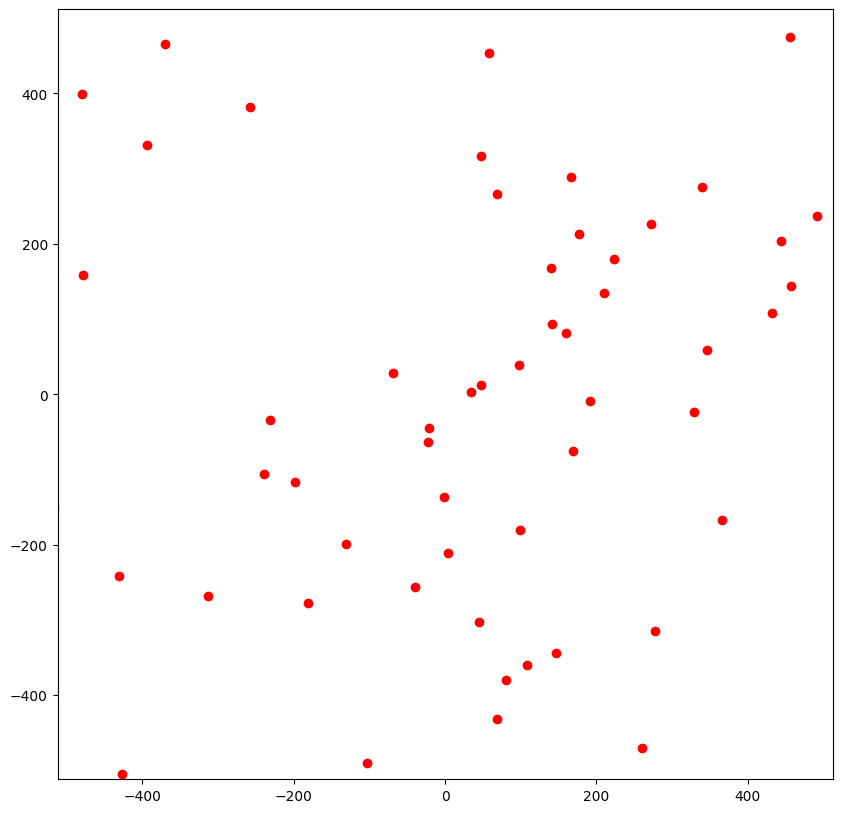

In [47]:
# Display sources in SAMOS Spectral Inst. CCD coordinates

%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(RA_Offsets_IMpix, DEC_Offsets_IMpix, 'ro')
plt.axis([-512, 512, -512, 512])
plt.show()

In [48]:
# OFFsets in in SAMI pixels (SAMOS-SP Channel)
SP_CCD_Scale = 0.133
#
RA_Offsets_SPpix = RA_Offsets / SP_CCD_Scale # in pixels
DEC_Offsets_SPpix = DEC_Offsets / SP_CCD_Scale
print(np.c_[RA_Offsets_SPpix[0:5], DEC_Offsets_SPpix[0:5]])

# OFFsets in in SpecIns pixels (SAMOS-IM Channel)
IM_CCD_Scale = 0.17578125 #180/1024
#
RA_Offsets_IMpix = RA_Offsets / IM_CCD_Scale # in pixels
DEC_Offsets_IMpix = DEC_Offsets / IM_CCD_Scale
print(np.c_[RA_Offsets_IMpix[0:5], DEC_Offsets_IMpix[0:5]])


[[-324.48906349 -143.2105725 ]
 [  64.24181109  428.46658079]
 [1141.96100159   97.54040085]
 [ -93.29006542   37.78169929]
 [ 190.64081994  125.64881351]]
[[-245.51563631 -108.35630161]
 [  48.60678187  324.18733651]
 [ 864.03307071   73.80123485]
 [ -70.58533661   28.58647328]
 [ 144.24308083   95.0686845 ]]


##  Display the sources in a) the Spectral Instrument,  and b) the SAMI/SAMOS field of view, assumed centered in the CCD field, assumed centered in the middle of the 4098x4098 detector

<Figure size 1000x300 with 0 Axes>

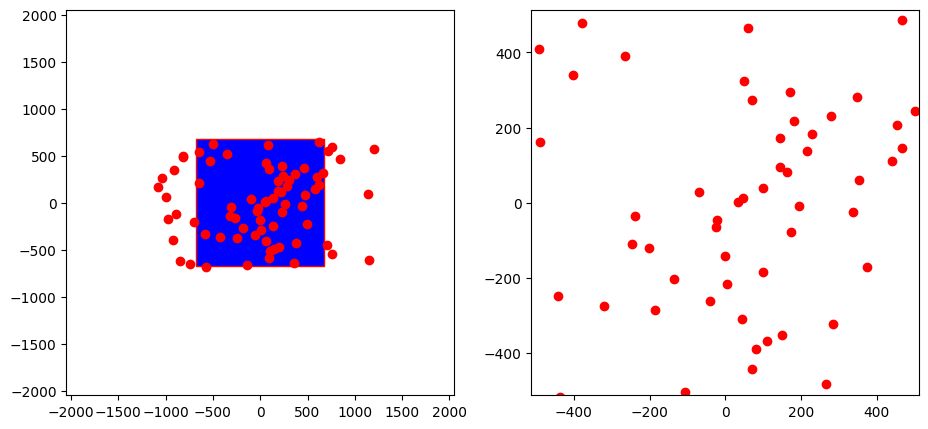

In [49]:
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#%matplotlib inline
f = plt.figure(figsize=(10,3))
x1,x2=plt.subplots(1, 2, figsize=(11,5))
x1=plt.subplot(1, 2, 1)
x1.plot(RA_Offsets_SPpix, DEC_Offsets_SPpix, 'ro')
x1.axis([-2048, 2048, -2048, 2048])
rectangle = plt.Rectangle((-675,-675),1350, 1350, fc='blue',ec="red")
plt.gca().add_patch(rectangle)

x2=plt.subplot(1, 2, 2)
x2.plot(RA_Offsets_IMpix, DEC_Offsets_IMpix, 'ro')
x2.axis([-512, 512, -512, 512])

plt.show()


## Display the trace of the spectra in SAMI/SAMOS field of view, assumed 2000 pixels long.

/Users/robberto/Desktop/SAMOS-DMD-Tools/NGC 3105/NGC 3105-T00_slits.png


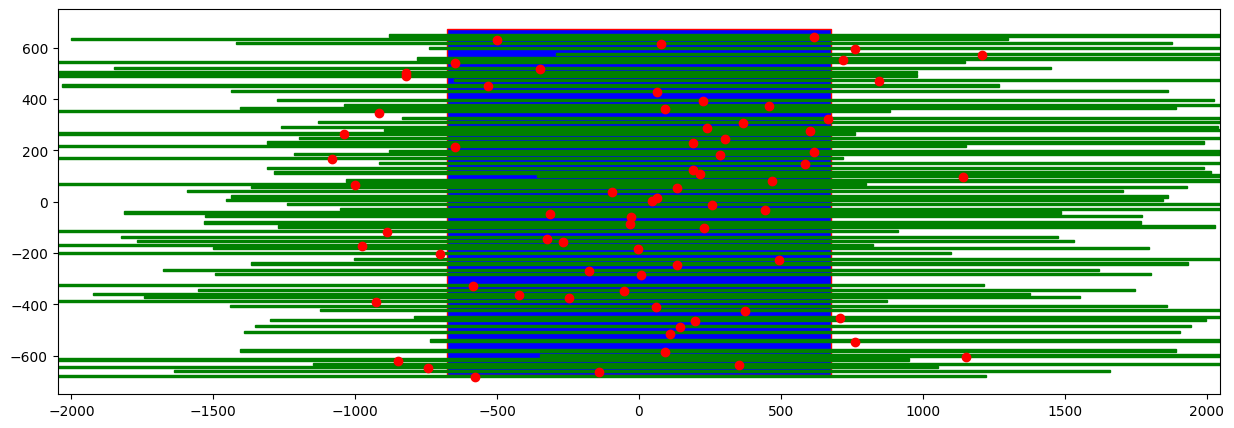

In [50]:
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
plt.figure(figsize=(15,5))
plt.plot(RA_Offsets_SPpix, DEC_Offsets_SPpix, 'ro')
plt.axis([-2048, 2048, -750, 750])
rectangle = plt.Rectangle((-675,-675),1350, 1350, fc='blue',ec="red")
plt.gca().add_patch(rectangle)
for i in range(len(RA_Offsets_IMpix)):
#    print(RA_Offsets_IMpix.iloc[i])
#    print(np.round(RA_Offsets_IMpix.iloc[i]-1),np.round(DEC_Offsets_IMpix.iloc[i]-1000,3, np.round(DEC_Offsets_IMpix.iloc[i]+1000))
    xy = (RA_Offsets_SPpix.iloc[i]-1500,np.round(DEC_Offsets_SPpix.iloc[i]))
    rectangle = plt.Rectangle(xy ,3300, 9, fc='green',ec="green")
    plt.gca().add_patch(rectangle)


#do you reallhy want to save these plots?
fileout= os.path.join(cwd, Target_name, Target_name+"-T"+"{:02d}".format(it)+'_slits.png')
print(fileout)
plt.savefig(fileout)
plt.show()

# GUIDE STARS

Given the rotation of the field, compensated adding an offset to the rotator, guide Stars must be searched in advance. We will use GAIA coordinates.

From R. Barkhouser e-mail, June 10, 2024: 

"From what I can determine, there is a $$34.5^\circ$$ rotation between the SAM and SAMOS field orientations.  I think that matches up (within 0.5 deg) to the 124 deg rotation you found for the x-flipped field (90 deg + 34 deg).  See attached..."

In [51]:
Angle = -34.5*u.deg

In [52]:
#import shutil
#import tempfile#import urllib.request
#from astropy.io import fits
#from astropy.wcs import WCS

# SOUTHERN HEMISPHERE: USE SKY MAPPER IMAGE

string="https://api.skymapper.nci.org.au/public/siap/dr4/get_image?IMAGE=20140425124821-10&SIZE=0.0833&POS=189.99763,-11.62305"

target_url = string
hdu = fits.open(target_url)[0]
wcs = WCS(hdu.header)
wcs

In [53]:
#loop over the images to get the first one with the minimum distance
mini = d_from_center[0]
i_mini = 0
for i in range(len(im_table)):
#    print(i,d_from_center[i],mini)
    if d_from_center[i] < mini:
        mini = d_from_center[i]
        i_mini=i
#print(i_mini)
#print(im_table[i_mini].getdataurl())


In [54]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 19 22:05:04 2023

@author: robberto
"""
#import urllib.request
#import shutil
#import tempfile#import urllib.request
#from astropy.io import fits


def skymapper_interrogate(POSx=189.99763, POSy=-11.62305, RA_Size=1058, DEC_Size=1032, filter='r'):
    POS = str(POSx)+","+str(POSy)   #"189.99763,-11.62305"
   # Sizex = np.round(0.18 / 3600 * RA_Size, 6)
   # Sizey = np.round(0.18 / 3600 * DEC_Size, 6)
    Sizex = 0.18 / 3600 * RA_Size
    Sizey = 0.18 / 3600 * DEC_Size
    SIZE = str(Sizex) + "," + str(Sizey)  #"0.05,0.1"
    FILTERS  = filter  #"g"#"g,r,i"
    string0= 'https://api.skymapper.nci.org.au/public/siap/dr2/'
    string = string0 + "query?"
    string += 'POS=' + POS + '&'
    string += 'SIZE=' + '0.05' + '&'   # first call to find the plate we use a small 5'x5' field
    string += 'BAND=' + FILTERS + '&'
    string += 'FORMAT=image/fits&INTERSECT=covers'#'&MJD_END=56970'#'&RESPONSEFORMAT=CSV'
    
    with urllib.request.urlopen(string,timeout=30) as response:
       html = response.read()
    #print(html)
    
    #v=pd.read_csv(html)
    v=html.decode('UTF-8')
    
    #entrypoint  = v.find("\nSkyMapper")   #use this if &RESPONSEFORMAT=CSV' works
    #image_number = v[entrypoint+13:entrypoint+30]
 
    entrypoint = []
    [entrypoint.append(m.start()) for m in re.finditer(">SkyMapper_", v)] 

    min_d = 100.
    i_min_d = 0
    best_image = ""

    for i in range(len(entrypoint)):
    #    entrypoint_old  = v.find(">SkyMapper_")
        image_number = v[entrypoint[i]+13:entrypoint[i]+30]
        #print("a",entrypoint,image_number)
        
        string = string0 + "get_image?"
        string += 'IMAGE='+image_number + '&'
        string += 'SIZE=' + SIZE + '&'
        string += 'POS=' + POS + '&'
        string += 'BAND=' + FILTERS + '&'
        string += 'FORMAT=fits'

        Sizex = 0.18 / 3600 * 1058
        Sizey = 0.18 / 3600 * 1038
        SIZE_SAMOS = str(Sizex) + "," + str(Sizey)  #"0.05,0.1"
        string_SAMOS = string0 + "get_image?"
        string_SAMOS += 'IMAGE='+image_number + '&'
        string_SAMOS += 'SIZE=' + SIZE_SAMOS + '&'
        string_SAMOS += 'POS=' + POS + '&'
        string_SAMOS += 'BAND=' + FILTERS + '&'
        string_SAMOS += 'FORMAT=fits'
        
        #print(string)
        #print(string_SAMOS)
        
        #https://api.skymapper.nci.org.au/public/siap/dr2/get_image?IMAGE=20140425124821-10&SIZE=0.05,0.1&POS=189.99763,-11.62305&BAND=g&FORMAT=fits
        #https://api.skymapper.nci.org.au/public/siap/dr2/get_image?IMAGE=20140425124821-10&SIZE=0.0833&POS=189.99763,-11.62305&FORMAT=png
        #string='https://api.skymapper.nci.org.au/public/siap/dr2/query?POS=150.17110,-54.79004&SIZE=0.052899999999999996,0.05159999999999999&BAND=i&FORMAT=image/fits&INTERSECT=covers&MJD_END=56970'
        """
        #Fetching URLs
        #FROM https://docs.python.org/3/howto/urllib2.html
        """
        
        with urllib.request.urlopen(string,timeout=30) as response:
            #print("a")
            with tempfile.NamedTemporaryFile(delete=False) as tmp_file:
            #    print("b")
                shutil.copyfileobj(response, tmp_file)
        with open(tmp_file.name) as html:
            #print("c")
            pass
            
        with urllib.request.urlopen(string_SAMOS,timeout=30) as response_SAMOS:
            #print("d")
            with tempfile.NamedTemporaryFile(delete=False) as tmp_file_SAMOS:
            #    print("e")
                shutil.copyfileobj(response_SAMOS, tmp_file_SAMOS)
        with open(tmp_file_SAMOS.name) as html:
            #print("f")
            pass
        
        
        hdu_in = fits.open(tmp_file.name)
        header = hdu_in[0].header
        #print(header)
        NAXIS1 = header['NAXIS1']
        NAXIS2 = header['NAXIS2']
        #import astropy.wcs as wcs
        #mywcs = wcs.WCS(header)
        mywcs = WCS(header)
        ra_center_skymapper, dec_center_skymapper = mywcs.all_pix2world([[NAXIS1/2,NAXIS2/2]], 0)[0]
        # Locate and download an image of interest
        #There are multiple images, we want to take the one that is centered closed to our target to get full field coverage
        #calculate the distances from tall the center images
        print(ra_center_skymapper,Posx,np.cos(dec_center_skymapper*u.deg),dec_center_skymapper,Posy)
        d_from_center= np.sqrt( ( (ra_center_skymapper-Posx)/np.cos(dec_center_skymapper*u.deg))**2 +
                        (dec_center_skymapper-Posy)**2 )
        #check:
        #print(d_from_center)
        #print(best_image)
        if d_from_center < min_d:
            min_d = d_from_center
            i_min_d=i
            best_image=tmp_file
            best_image_SAMOS = tmp_file_SAMOS
            print(best_image_SAMOS)


        #data = hdu_in[0].data
        
        #import astropy.wcs as wcs
        #mywcs = wcs.WCS(header)
        #ra, dec = mywcs.all_pix2world([[data.shape[0]/2,data.shape[1]/2]], 0)[0]
        #header['RA'] = ra
        #header['DEC'] = dec
        #fits.writeto(tmp_file, data, header=header, overwrite=True)
    #print(best_image.name)
    #print(best_image_SAMOS.name)
    SkyMapper_query(best_image_SAMOS)
    if ((RA_Size == 1058) and (DEC_Size == 1032)) or ((RA_Size == 2560) and (DEC_Size == 2560)):
        return(best_image)
    elif np.absolute(header['NAXIS1'] - header['NAXIS2']) <= 1:
        return(best_image)
        
#    from astropy.io import fits
#    hdu = fits.open(tmp_file.name)[0]
#    image = hdu.data
#    header = hdu.header
#    return(hdu)
"""
    Inject image from SkyMapper to create a WCS solution using twirl
    """

def SkyMapper_query(filepath):
    print("enter here")
    """ get image from SkyMapper """
    #print("aa",filepath.name)

    #img = AstroImage()
    #Posx = str(radec_center.ra.value[0])
    #Posy = str(radec_center.dec.value[0])
    #filt ="g"
    #filepath = skymapper_interrogate(Posx, Posy, 1058, 1032, filt)
    # filepath = skymapper_interrogate_VOTABLE(Posx, Posy, filt)
    hdu_in = fits.open(filepath.name)
    #            img.load_hdu(hdu_in[0])
    data = hdu_in[0].data
    from PIL import Image
    image_data = Image.fromarray(data)
    img_res = image_data.resize(size=(1032, 1056))
    hdu_res = fits.PrimaryHDU(img_res)
        # ra, dec in degrees
    
    #ra = str(Posx)
    #dec = str(Posy)
    #hdu_res.header['RA'] = str(Posx)
    #hdu_res.header['DEC'] = Posy

    output_header = copy.deepcopy(hdu_res.header) # copy.deepcopy(hdu_in[0].header)
        #main_fits_header.add_astrometric_fits_keywords(hdu_res.header)
        #            rebinned_filename = "./SkyMapper_g_20140408104645-29_150.171-54.790_1056x1032.fits"
        #           hdu.writeto(rebinned_filename,overwrite=True)
        
    #    output_header['RA'] = ra
    #    output_header['DEC'] = dec
    output_header['WCSAXES'] = 2 #/ Number of coordinate axes       
    output_header['NAXIS1'] = float(1056)
    output_header['NAXIS2'] = float(1032)
    output_header['CRVAL1'] = str(Posx)
    output_header['CRVAL2'] = Posy
    output_header['CRPIX1'] = float(528)
    output_header['CRPIX2'] = float(516)
    output_header['CDELT1'] = -0.18 / 3600
    output_header['CDELT2'] = 0.18 / 3600
    output_header['CUNIT1'] = 'deg'
    output_header['CUNIT2'] = 'deg'
    output_header['CTYPE1']  = 'RA---SIN'          # / Right ascension, orthographic/synthesis project
    output_header['CTYPE2']  = 'DEC--SIN'          # / Declination, orthographic/synthesis projection
    output_header['RADESYS'] = 'FK5'               # / Equatorial coordinate system                   
    output_header['EQUINOX'] = 2000.0 #/ [yr] Equinox of equatorial coordinates
        
        
    filter=hdu_in[0].header['FILTER']
        
        #import astropy.wcs as wcs
        #wcs =wcs.WCS(output_header)      

        #img.load_hdu(hdu_res)

        #self.fitsimage.set_image(img)
        #self.AstroImage = img
        #self.fullpath_FITSfilename = filepath.name
    hdu_in.close()

    fits_image_ql = os.path.join(dir_name, Target_name+"_SkyMapper_"+filter+"_"+radec_center[0].to_string()+".fits")
    fits.writeto(fits_image_ql, hdu_res.data,
                     ##                     header=self.hdu_res.header, overwrite=True)
                     header=output_header, overwrite=True)

        #self.fitsimage.rotate(self.PAR.Ginga_PA)  
        #self.Display(self.fits_image_ql)
        #self.button_find_stars['state'] = 'active'
        #self.wcs_exist = True

In [55]:
#filt ="g"
#filepath = skymapper_interrogate(str(Posx), str(Posy), 2560, 2560, filt)


In [56]:
#print(filepath)

In [57]:
if Posy < 0:
    
    filt ="g"
    filepath = skymapper_interrogate(str(Posx), str(Posy), 2560, 2560, filt)
    #print(filepath)
    #print(radec_center.ra.hms,radec_center.dec)
    
    dra = 0.05/np.cos(Posy*u.deg) 
    ddec = 0.05
    
    hdu = fits.open(filepath.name)[0]
    wcs = WCS(hdu.header)
    
    # Pixel coordinates of the center
    xc, yc = wcs.world_to_pixel(radec_center)
    #print(xc, yc)
    
    #if region_sky.contains(center_sky,wcs) and (gs1_region_sky.contains(center_sky,wcs) or gs2_region_sky.contains(center_sky,wcs)):
    #    print("skip")
    


150.19403695132004 150.16916666666665 0.5765810450782589 -54.789570899922865 -54.79
150.1584033931327 150.16916666666665 0.5765728239294624 -54.79014741451055 -54.79
150.136290837711 150.16916666666665 0.5765669201092851 -54.79056142206324 -54.79
enter here


# NORTHERN HEMISPHERE: PANSTARRS

## From https://ps1images.stsci.edu/ps1image.html: Get image from the PS1 image server

Query the PS1 image server to get a list of images and retrieve some images. This sample script demonstrates the use of the PS1 image services. See the PS1 Image Cutout Service documentation for details of the services being used. This notebook is available for download.

In [58]:
if 1 == 1:#radec_center.dec.value[0] >0:
    #import numpy
    from astropy.table import Table
    import requests
    from PIL import Image
    from io import BytesIO
    import matplotlib.pyplot as plt

## Helper functions to query the list of images and to extract images

In [59]:
def getimages(ra,dec,filters="grizy"):
    """Query ps1filenames.py service to get a list of images
        
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
        
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    table = Table.read(url, format='ascii')
    return table
    
def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
        
    """Get URL for images in the table
        
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
        
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={format}")
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url
    
def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
        
    """Get color image at a sky position
        
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
        
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im
    
    
def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
        
    """Get grayscale image at a sky position
        
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
        
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

## Sample JPEG images

This gets single-band grayscale and color JPEG images at the position of the Crab Nebula. The extracted region size is 1280 pixels = 320 arcsec (0.25"/pixel)

In [60]:
#ra = radec_center.ra.value[0]
#dec = radec_center.dec.value[0]
if radec_center.dec.value[0] >0:
    # Crab Nebula position
    #ra_0 = radec_center.ra.value[0]
    #dec_0 = radec_center.dec.value[0]
    size = 1280
    size = 1600 #400 arcsec
    
    # grayscale image
    gim = getgrayim(Posx, Posy,size=size,filter="i")
    # color image
    cim = getcolorim(Posx,Posy,size=size,filters="grz")
    
    plt.rcParams.update({'font.size':12})
    plt.figure(1,(12,6))
    plt.subplot(121)
    plt.imshow(gim,origin="upper",cmap="gray")
    plt.title('Crab Nebula PS1 i')
    plt.subplot(122)
    plt.title('Crab Nebula PS1 grz')
    plt.imshow(cim,origin="upper")

## Load and display a FITS image

Note that the  𝑦
 -axis is flipped in the JPEG image compared with the original FITS image.



In [61]:
if Posy >0:
    filter = 'i'
    filepath = geturl(Posx, Posy, size=size, filters=filter, format="fits")
    filepath_name = filepath[0]
    fh = fits.open(filepath[0])
    fh.writeto(dir_name+"/"+Target_name+"_PanStarrs_"+filter+"_"+radec_center[0].to_string()+".fits",overwrite=True)

In [62]:
#print(dir_name+"/"+Target_name+"_"+radec_center[0].to_string()+".jpg")

In [63]:
if Posy >0:
    #from astropy.io import fits
    from astropy.visualization import PercentileInterval, AsinhStretch
    
    filepath = geturl(Posx, Posy, size=size, filters="i", format="fits")
    fh = fits.open(filepath[0])
    fim = fh[0].data
    # replace NaN values with zero for display
    fim[np.isnan(fim)] = 0.0
    # set contrast to something reasonable
    transform = AsinhStretch() + PercentileInterval(99.5)
    bfim = transform(fim)
    
    plt.figure(1,(12,6))
    plt.subplot(121)
    plt.imshow(gim,cmap="gray",origin="upper")
    plt.title('Crab Nebula PS1 i (jpeg)')
    #plt.savefig("../Target_"+radec_center.to_string()+".jpg")
    
    plt.subplot(122)
    plt.title('Crab Nebula PS1 i (fits)')
    plt.imshow(bfim,cmap="gray",origin="lower")
    plt.savefig(dir_name+"/"+Target_name+"_PanStarrs_"+filter+"_"+radec_center.to_string()[0]+".jpg")

Extract the hdu

In [64]:
if Posy >0:
    hdu=fh[0]
    wcs = WCS(hdu.header)
    wcs

In [65]:
#if radec_center.dec.value[0] >0:
#Posx = str(radec_center.ra.value[0])
#Posy = str(radec_center.dec.value[0])
print(str(Posx),str(Posy))
r_coord = SkyCoord(
        ra=r_Gaia['ra'], 
        dec=r_Gaia['dec'],
        #distance=Distance(parallax=r_Gaia['parallax']),
        pm_ra_cosdec=r_Gaia['pmra'],
        pm_dec=r_Gaia['pmdec'],
        obstime=Time(r_Gaia['ref_epoch'], format='jyear'))
print(Time.now())
r_coord_today  = r_coord.apply_space_motion(
            new_obstime=Time.now())# Time('J1950'))
r_Gaia['ra_now']=r_coord_today.ra.deg
r_Gaia['dec_now']=r_coord_today.dec.deg

150.16916666666665 -54.79
2024-07-26 10:36:47.657580


/opt/anaconda3/envs/stenv-py3.11-2024.02.05/lib/python3.11/site-packages/erfa/core.py:5020: RuntimeWarning: invalid value encountered in pmsafe
  ra2, dec2, pmr2, pmd2, px2, rv2, c_retval = ufunc.pmsafe(
/opt/anaconda3/envs/stenv-py3.11-2024.02.05/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 939 of "distance overridden (Note 6)", 104 of "binary logical OR of the above warnings"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [66]:
if 1==1:#radec_center.dec.value[0] < 0:
    # FIX The GAIA COORDINATES TO THE EPOCH OF OBSERVATION
    #from astropy.coordinates import SkyCoord, Distance, Galactic
    from astropy.time import Time
    
    r_coord = SkyCoord(
        ra=r_Gaia['ra'], 
        dec=r_Gaia['dec'],
        #distance=Distance(parallax=r_Gaia['parallax']),
        pm_ra_cosdec=r_Gaia['pmra'],
        pm_dec=r_Gaia['pmdec'],
        obstime=Time(r_Gaia['ref_epoch'], format='jyear'))
    
    print(Time.now())
    
    r_coord_today  = r_coord.apply_space_motion(
            new_obstime=Time.now())# Time('J1950'))
    
    r_Gaia['ra_now']=r_coord_today.ra.deg
    r_Gaia['dec_now']=r_coord_today.dec.deg

2024-07-26 10:36:47.684544


In [67]:
#print(r_coord_today.ra.arcsec[0:5])
#print(r_Gaia['ra'][0:5]*3600)

In [68]:
if 1==1:#radec_center.dec.value < 0:
    gaia_pdtable = r_Gaia.to_pandas()
    gaia_pdtable['placement']='out'

In [69]:
#print(radec_center.ra.value[0])


print(ra.real , radec_center.dec.value[0])
dra = 0.05/np.cos(ra*u.deg) 
print(([ra-dra.value/2.,dec-ddec/2.])*u.deg)
print((266.0, -28.9)*u.deg)

[375.4999362] [464.1188396]
INFO: Query finished. [astroquery.utils.tap.core]
         dist             solution_id             DESIGNATION          ... ebpminrp_gspphot_upper libname_gspphot
                                                                       ...          mag                          
--------------------- ------------------- ---------------------------- ... ---------------------- ---------------
0.0003127261998553652 1636148068921376768 Gaia DR3 5260177495457182464 ...                 1.0508           MARCS
0.0009619123885947958 1636148068921376768 Gaia DR3 5260177499778946688 ...                 0.5139           MARCS
0.0011583374118966229 1636148068921376768 Gaia DR3 5260177499769681024 ...                     --                
                  ...                 ...                          ... ...                    ...             ...
  0.11345674384813804 1636148068921376768 Gaia DR3 5260172964285318656 ...                     --                
   0.11349

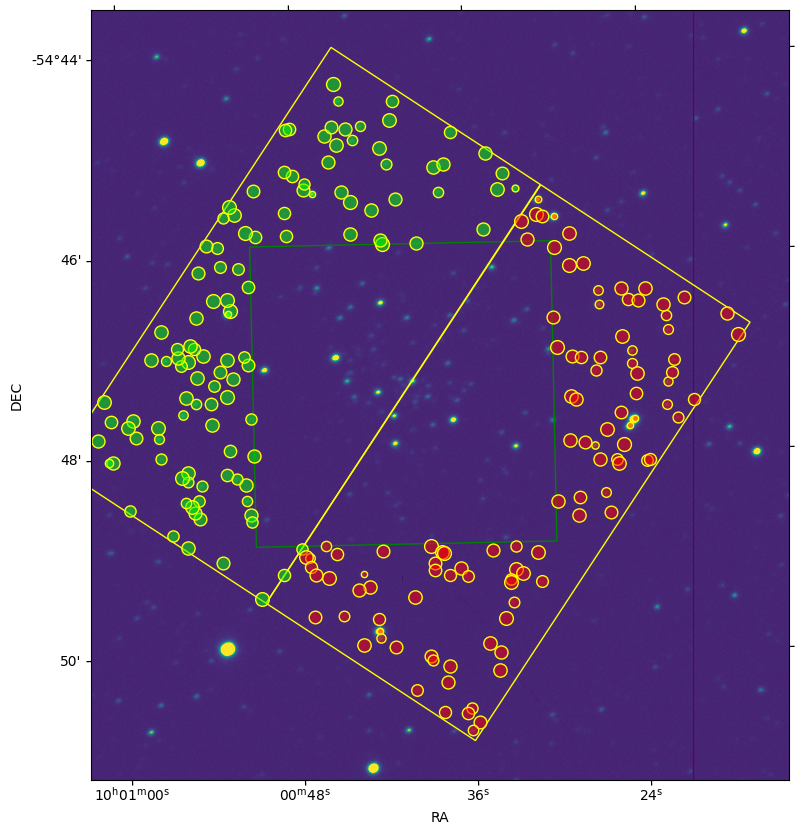

In [70]:
if 1 == 1:#radec_center.dec.value < 0:
    from astropy.coordinates import SkyOffsetFrame, ICRS
    #from astropy import units as u
    
    #radec_center=SkyCoord(ICRS(ra*u.deg,dec*u.deg))
    #Posx = str(radec_center.ra.value)
    #Posy = str(radec_center.dec.value)
    
    #print(radec_center.ra.hms,radec_center.dec)
    dra = 0.05/np.cos(Posy*u.deg) 
    ddec = 0.05
    
    #hdu = fits.open(filepath.name)[0]
    #wcs = WCS(hdu.header)
    
    x, y = wcs.world_to_pixel(radec_center)
    print(x, y)
    
    ax = plt.subplot(projection=wcs)
    vmin = hdu.data.mean()-hdu.data.std()*0.5
    vmax = hdu.data.mean()+hdu.data.std()*4
    ax.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    
    # example used in 
    # https://docs.astropy.org/en/stable/visualization/wcsaxes/overlays.html
    r = Quadrangle(([Posx-dra/2., Posy-ddec/2.])*u.deg, dra*u.deg, ddec*u.deg,
    #r = Quadrangle((266.0, -28.9)*u.deg, 0.03*u.deg, 0.015*u.deg,
                   edgecolor='green', facecolor='none',
                   transform=ax.get_transform('fk5'))
    ax.add_patch(r)
    
    
    #ax.grid(color='white', ls='solid')
    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    
    
    #from astropy.coordinates import SkyCoord
    #from astropy import units as u
    
    from regions import RectangleSkyRegion, RectanglePixelRegion
    from astropy.coordinates import SkyOffsetFrame, ICRS
    
    center_sky = SkyCoord(ICRS(Posx*u.deg, Posy*u.deg))
    region_sky = RectangleSkyRegion(center=center_sky,
                                    width=0.05 * u.deg, height=0.05 * u.deg)#                                angle=-20 * u.deg)
    region_sky_pixel=region_sky.to_pixel(wcs)
                                    
    dra_guide = 150/3600 *u.deg #/ np.cos(radec_center.dec.value[0]*u.deg) 
    ddec_guide = 300/3600 *u.deg # i.e. 100mm or +/-50mm * 2, corresponding to 150" * 2 = 300 (exactly should be 151.27")
    x1 = Posx*u.deg + dra_guide/2./np.cos(Posy*u.deg) *np.cos(Angle)
    y1 = Posy*u.deg + dra_guide/2.*np.sin(-Angle)
    center_sky_gs1=SkyCoord(ICRS(x1, y1))
    gs1_region_sky = RectangleSkyRegion(center=center_sky_gs1,
                                    width=dra_guide, height=ddec_guide,
                                    angle=Angle)
    gs1_region_sky_pixel=gs1_region_sky.to_pixel(wcs)
    
    x2 = Posx*u.deg - dra_guide/2./np.cos(Posy*u.deg) *np.cos(Angle)
    y2 = Posy*u.deg - dra_guide/2.*np.sin(-Angle)
    center_sky_gs2=SkyCoord(ICRS(x2, y2))
    gs2_region_sky = RectangleSkyRegion(center=center_sky_gs2,
                                    width=dra_guide, height=ddec_guide,
                                    angle=Angle)
    gs2_region_sky_pixel=gs2_region_sky.to_pixel(wcs)
    
    from gammapy.maps import RegionGeom
    #geom=RegionGeom(region_sky).plot_region()
    geom=RegionGeom(gs1_region_sky).plot_region(edgecolor="yellow")
    geom=RegionGeom(gs2_region_sky).plot_region(edgecolor="yellow")
    #geom.plot_region()

    #from astropy.coordinates import SkyCoord
    #from astroquery.gaia import Gaia
    
    coord = center_sky
    width = u.Quantity(0.20, u.deg)
    height = u.Quantity(0.20, u.deg)
    Gaia.ROW_LIMIT=-1.
    r_Gaia = Gaia.query_object_async(coordinate=coord, width=width, height=height)
    r_Gaia.pprint(max_lines=12, max_width=130)
    
    gaia_counter=0
    for i_star in range(len(r_Gaia['ra'])):
        circ=max(16*r_Gaia['phot_g_mean_mag'][i_star]-188,20)  #size of the circl on the display, 13mag->18mag radius goes 100->20
        gaia_coord=SkyCoord(ICRS(float(r_Gaia['ra'][i_star])*u.deg, float(r_Gaia['dec'][i_star])*u.deg))
    #    if (gs1_region_sky.contains(gaia_coord,wcs) or gs2_region_sky_pixel.contains(gaia_coord,wcs)):
        if gs1_region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs)):
            if region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs)):
                print(i_star,"GAIA SOURCE IS IN SAMOS FOV")
                gaia_pdtable.loc[i_star,'placement'] = 'in_field'
                continue
            else:
                if r_Gaia['phot_g_mean_mag'][i_star]<=18:
                    print(i_star,"GAIA SOURCE IS IN GS1")
                    ax.scatter(gaia_coord.ra.deg,gaia_coord.dec.deg, 
                       transform=ax.get_transform('fk5'),
                       s=circ, edgecolor='yellow', facecolor=(0, 1, 0, 0.5))
                    gaia_pdtable.loc[i_star,'placement'] = 'GS1'
        if gs2_region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs)): 
            if region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs)):
                print(i_star,"GAIA SOURCE IS IN SAMOS FOV")
                gaia_pdtable.loc[i_star,'placement'] = 'in_field'
                continue
    #        gs2_region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs))):
    #        if region_sky.contains(gaia_coord,wcs):
    #            print("skip")
    #        else:
            else:
                if r_Gaia['phot_g_mean_mag'][i_star]<=18:
                    print(i_star,"GAIA SOURCE IS IN GS2")
                    ax.scatter(gaia_coord.ra.deg,gaia_coord.dec.deg, 
                       transform=ax.get_transform('fk5'),
                       s=circ, edgecolor='yellow', facecolor=(1, 0, 0, 0.5))
                    gaia_pdtable.loc[i_star,'placement'] = 'GS2'
    #    gaia_counter+=1
    #    print(gaia_counter,"  keep")
    #    print(gaia_coord.ra.hms,gaia_coord.dec)
    
    plt.show  
    plt.gcf().set_size_inches(10, 10)
    plt.savefig(dir_name+"/"+Target_name+"-GAIA_in_GS_"+radec_center[0].to_string()+".jpg", dpi=200)

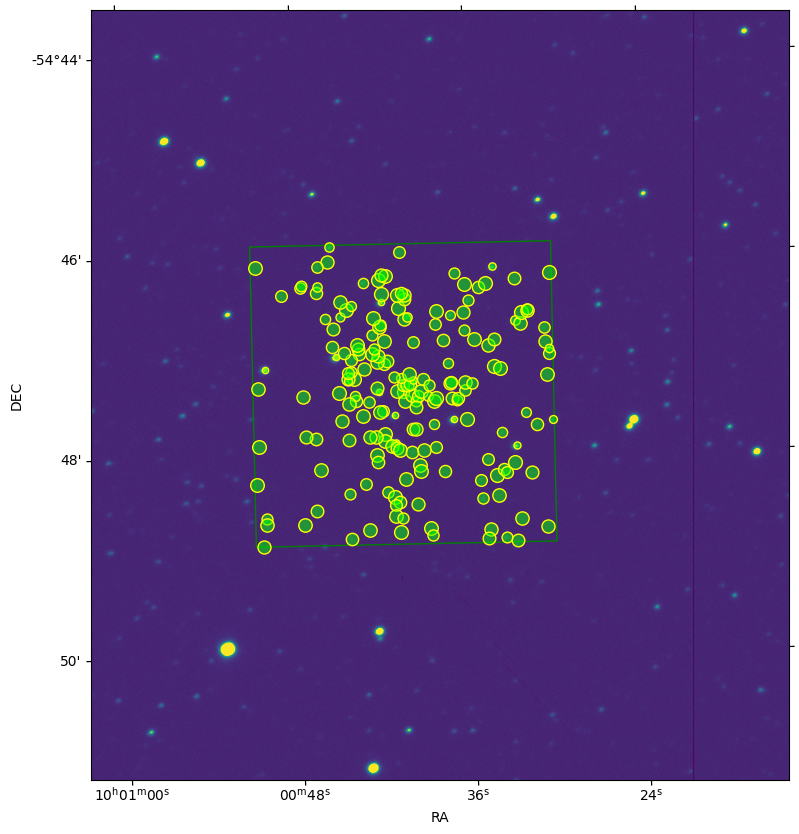

In [71]:
ax = plt.subplot(projection=wcs)
ax.imshow(hdu.data, vmin=vmin, vmax=vmax, origin='lower')
r = Quadrangle(([Posx-dra/2., Posy-ddec/2.])*u.deg, dra*u.deg, ddec*u.deg,
                   edgecolor='green', facecolor='none',
                   transform=ax.get_transform('fk5'))
ax.add_patch(r)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
    
for i_star in range(len(r_Gaia['ra'])):
    circ=max(16*r_Gaia['phot_g_mean_mag'][i_star]-188,20)  #size of the circl on the display, 13mag->18mag radius goes 100->20
    gaia_coord=SkyCoord(ICRS(float(r_Gaia['ra'][i_star])*u.deg, float(r_Gaia['dec'][i_star])*u.deg))
    #print(gaia_coord)
    if (region_sky_pixel.contains(PixCoord.from_sky(gaia_coord,wcs))) and  (r_Gaia['phot_g_mean_mag'][i_star] < 18):
        ax.scatter(gaia_coord.ra.deg,gaia_coord.dec.deg, 
           transform=ax.get_transform('fk5'),
           s=circ, edgecolor='yellow', facecolor=(0, 1, 0, 0.5))

plt.show  
plt.gcf().set_size_inches(10, 10)
plt.savefig(dir_name+"/"+Target_name+"-GAIA_in_field_"+radec_center[0].to_string()+".jpg", dpi=200)
    

In [72]:
if 1==1:#dec > 0:
    #print(gaia_pdtable['placement'])
    print(len(gaia_pdtable['placement'][gaia_pdtable['placement']=='in_field']))
    print(len(gaia_pdtable['placement'][gaia_pdtable['placement']=='GS1']))
    print(len(gaia_pdtable['placement'][gaia_pdtable['placement']=='GS2']))
    gaia_infield = gaia_pdtable[gaia_pdtable['placement']=='in_field']
    gaia_inGS1 = gaia_pdtable[gaia_pdtable['placement']=='GS1']
    gaia_inGS2 = gaia_pdtable[gaia_pdtable['placement']=='GS2']
    
    g0 = gaia_infield[["SOURCE_ID","ra_now","dec_now","phot_g_mean_mag"]].sort_values(by="phot_g_mean_mag")
    g1 = gaia_inGS1[["SOURCE_ID","ra_now","dec_now","phot_g_mean_mag"]].sort_values(by="phot_g_mean_mag")
    g2 = gaia_inGS2[["SOURCE_ID","ra_now","dec_now","phot_g_mean_mag"]].sort_values(by="phot_g_mean_mag")
    
    print(g0.dropna(inplace = True))
    print(g1.dropna(inplace = True))
    print(g2.dropna(inplace = True))
    
    g0.to_csv(dir_name+"/"+Target_name+"-GAIA_in_field_"+radec_center[0].to_string()+".csv")
    g1.to_csv(dir_name+"/"+Target_name+"-GAIA_in_GS1_"+radec_center[0].to_string()+".csv")
    g2.to_csv(dir_name+"/"+Target_name+"-GAIA_in_GS2_"+radec_center[0].to_string()+".csv")






889
115
109
None
None
None


In [73]:
#g2 = gaia_inGS2[["SOURCE_ID","ra_now","dec_now","phot_g_mean_mag"]].sort_values(by="phot_g_mean_mag")
#g2

In [74]:
README_File = dir_name+"/"+Target_name+"_README.txt"
f = open(README_File, 'w')
stringa=Target_name+"-GAIA_in_GS2_"+radec_center[0].to_string()+".csv"
f.write(stringa+': Gaia sources in GS2, for GS acq.\n')
stringa=Target_name+"-GAIA_in_GS1_"+radec_center[0].to_string()+".csv"
f.write(stringa+': Gaia sources in GS1, for GS acq.\n')
stringa=Target_name+"-GAIA_in_field_"+radec_center[0].to_string()+".csv"
f.write(stringa+': Gaia sources in target field, for astrometry\n')

stringa  = Target_name+"-GAIA_in_field_"+radec_center[0].to_string()+".jpg"
f.write(stringa+': 2MASS Field Image\n')
stringa  = Target_name+"-GAIA_in_GS_"+radec_center[0].to_string()+".jpg"
f.write(stringa+': Plot of Gaia sources in GS fields\n')
if Posy > 0:
    stringa = Target_name+"_PanStarrs_"+filter+"_"+radec_center.to_string()[0]+".jpg"
#stringa=Target_name+"_2Mass_"+filter+"_"+radec_center[0].to_string()+".fits"
    f.write(stringa+': PanStarrs JPG image of target field\n')
    stringa = Target_name+"_PanStarrs_"+filter+"_"+radec_center[0].to_string()+".fits"
    f.write(stringa+': PanStarrs FITS image of target field\n')
if Posy < 0:
    stringa = Target_name+"_SkyMapper_"+filter+"_"+radec_center[0].to_string()+".fits"
    f.write(stringa+': SkyMapper FITS image of target field\n')

stringa=Target_name+"_2Mass_"+filter+"_"+radec_center[0].to_string()+".fits"
f.write(stringa+': 2MASS Field Image\n')

f.close()